# Metric analysis

The folowing notebook presents **statistical** and **machine learning based** methods to analyze and select the most meaningfull features that predict the human score within a dataset of metrics

### Loading

In [3]:
from datasets import load_dataset

full_df = load_dataset(
    "CharlyR/varbench-metric-evaluation", "treated_new", split="train"
).to_pandas()#TODO switch to treated_new
df = full_df[
    [
        col_name
        for col_name in full_df.columns
        if any(keyword in col_name for keyword in ["Metric", "human_score", "id","config"])
    ]
]

len(df)

Generating train split: 100%|██████████| 445/445 [00:00<00:00, 11204.15 examples/s]


445

In [ ]:
grped = (
    df.groupby(list(set(df.columns) - {"human_score"}))
    .mean()
    .round(0)  # Round to the nearest integer
    .astype(int)  # Convert to integer type
    .reset_index()
)
df = grped
df.dtypes

TERPatchMetric            float32
CrystalBleuMetric         float32
PSNRMetric                float32
MSSSIMMetric              float32
CrystalBleuPatchMetric    float32
TERMetric                 float32
LPIPSMetric               float32
BleuMetric                float32
id                         object
LineMetric                float32
ChrfPatchMetric           float32
ClipTextMetric            float32
reviewer_id                object
FeatureMatchMetric        float32
PatchMetric               float32
ClipImageMetric           float32
BleuPatchMetric           float32
ChrfMetric                float32
MSEMetric                 float32
config                     object
human_score                 int64
dtype: object

### Statistical-based analysis

#### correlation

In [5]:
import metric_utils
import pandas as pd
import seaborn as sns
cmap = sns.diverging_palette(230, 20, as_cmap=True)

##### Full

<Axes: >

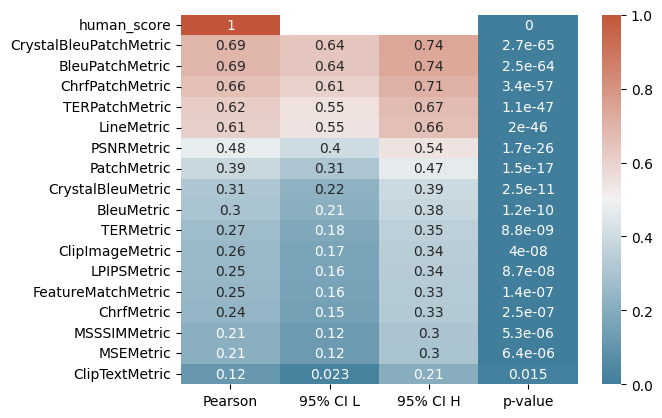

In [6]:
sorted_corr = metric_utils.pearson_confidence_interval(df.drop(columns=["id","config"])).sort_values(by="Pearson", ascending=False).drop(columns=["metric"])
sorted_corr = sorted_corr.apply(pd.to_numeric)
sns.heatmap(sorted_corr, annot=True, cmap=cmap)

<Axes: >

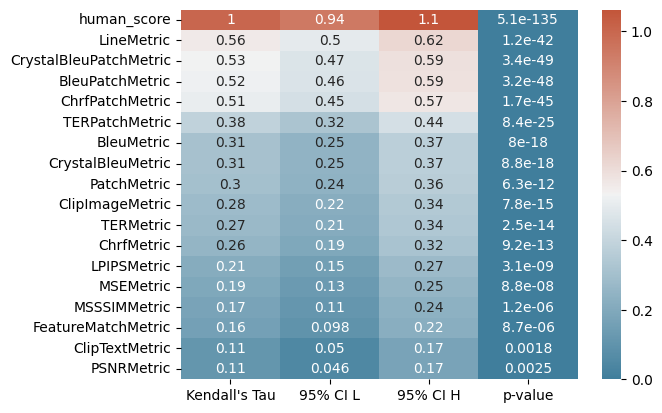

In [7]:
sorted_corr = metric_utils.kendall_confidence_interval(df.drop(columns=["id","config"])).sort_values(by="Kendall's Tau", ascending=False).drop(columns=["metric"])
sorted_corr = sorted_corr.apply(pd.to_numeric)
sns.heatmap(sorted_corr, annot=True, cmap=cmap)

##### Segment(summary-level)

/home/creux/Documents/AI/MetricBench/analysis/metric_utils.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  se = 1 / np.sqrt(n - 3)
/home/creux/Documents/AI/MetricBench/analysis/metric_utils.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  se = 1 / np.sqrt(n - 3)
/home/creux/Documents/AI/MetricBench/analysis/metric_utils.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  se = 1 / np.sqrt(n - 3)
/home/creux/Documents/AI/MetricBench/analysis/metric_utils.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  se = 1 / np.sqrt(n - 3)
/home/creux/Documents/AI/MetricBench/analysis/metric_utils.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  se = 1 / np.sqrt(n - 3)
/home/creux/Documents/AI/MetricBench/analysis/metric_utils.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  se = 1 / np.sqrt(n - 3)
/home/creux/Documents/AI/MetricBench/analysis/metric_utils.py:27: RuntimeWarning: divide

<Axes: ylabel='metric'>

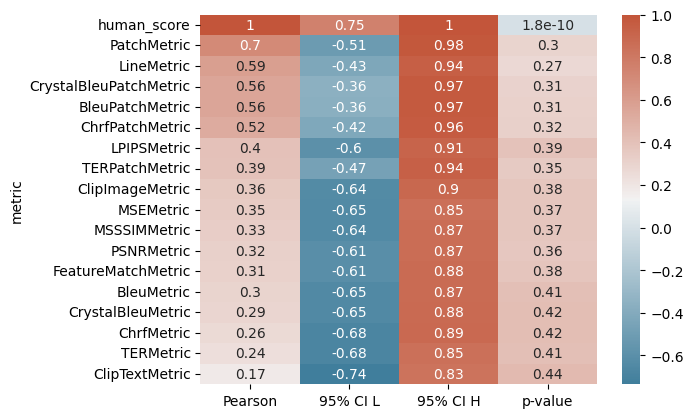

In [8]:
grouped_corr = df.drop(columns=["config"]).groupby("id").apply(metric_utils.pearson_confidence_interval).reset_index(drop=True)
sorted_corr = grouped_corr.groupby("metric")[["Pearson", "95% CI L", "95% CI H","p-value"]].mean().sort_values(by="Pearson", ascending=False)
sorted_corr = sorted_corr.apply(pd.to_numeric)
sns.heatmap(sorted_corr, annot=True, cmap=cmap)

/tmp/ipykernel_1064728/2539838563.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_corr = df.drop(columns=["config"]).groupby("id").apply(metric_utils.kendall_confidence_interval).reset_index(drop=True)


<Axes: ylabel='metric'>

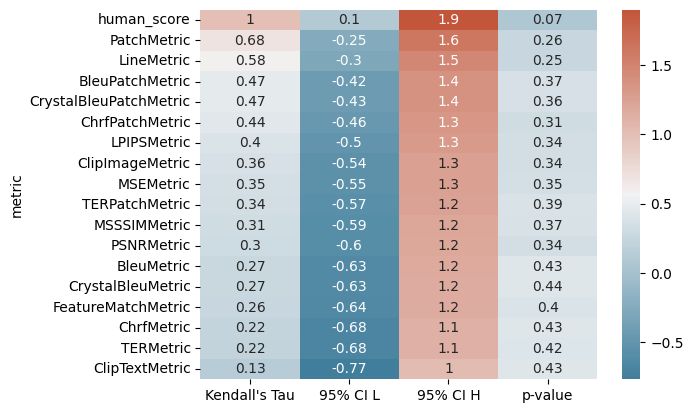

In [9]:
grouped_corr = df.drop(columns=["config"]).groupby("id").apply(metric_utils.kendall_confidence_interval).reset_index(drop=True)
sorted_corr = grouped_corr.groupby("metric")[["Kendall's Tau", "95% CI L", "95% CI H","p-value"]].mean().sort_values(by="Kendall's Tau", ascending=False)
sorted_corr = sorted_corr.apply(pd.to_numeric)
sns.heatmap(sorted_corr, annot=True, cmap=cmap)

##### System

In [ ]:
sorted_corr = (
    metric_utils.pearson_confidence_interval(
        df.drop(columns=["id"]).groupby("config").mean()
    )
    .sort_values(by="Pearson", ascending=False)
    .drop(columns=["metric"])
    .apply(pd.to_numeric)
)
sns.heatmap(sorted_corr, annot=True, cmap=cmap)

TypeError: agg function failed [how->mean,dtype->object]

<Axes: >

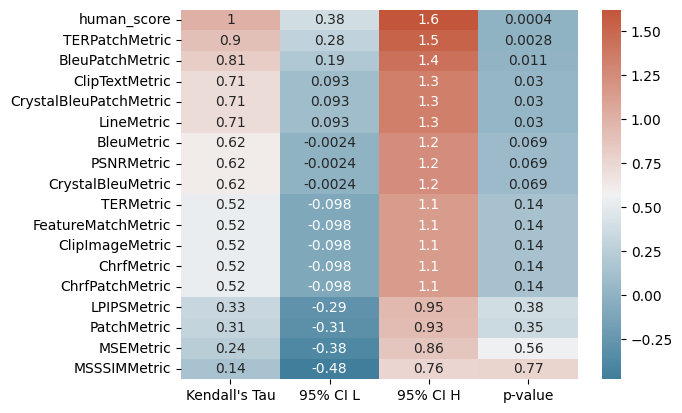

In [9]:
sorted_corr = (
    metric_utils.kendall_confidence_interval(
        df.drop(columns=["id"]).groupby("config").mean()
    )
    .sort_values(by="Kendall's Tau", ascending=False)
    .drop(columns=["metric"])
    .apply(pd.to_numeric)
)
sns.heatmap(sorted_corr, annot=True, cmap=cmap)

#### Univariate Feature Selection

ANOVA,F-Test and mutual information 


=> ANOVA finds linear dependencies between features, using comparisons between mean and variances between groups ( a feature has more predictive power if its group's means are separated and the variances of these groups are low), F-test is the same as ANOVA with means only
=> Mutual Information uses entropy: I(x,y) = H(y) - H(y|x) 


Notes: Chi2, ANOVA and F-tests are more relevant for categorical features

In [128]:
from sklearn.model_selection import train_test_split

#X(features) are the metrics
X = df.drop("human_score",axis=1)
#Y is the human score
y = df["human_score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=123456)


In [129]:
from sklearn.feature_selection import (
    f_classif,
    f_regression,
    mutual_info_regression,
    chi2,
    SelectKBest,
)
import numpy as np


def compute_scores(feature_selection_alg):
    selector = SelectKBest(feature_selection_alg, k="all")
    selector.fit(X_train, y_train)
    #scores = -np.log10(selector.pvalues_)
    scores = selector.scores_
    #scores /= scores.max()
    return scores


ANOVA_scores = compute_scores(f_classif)
f_test_scores = compute_scores(f_regression)
mutual_info_scores = compute_scores(mutual_info_regression)
chi2_scores = compute_scores(chi2)

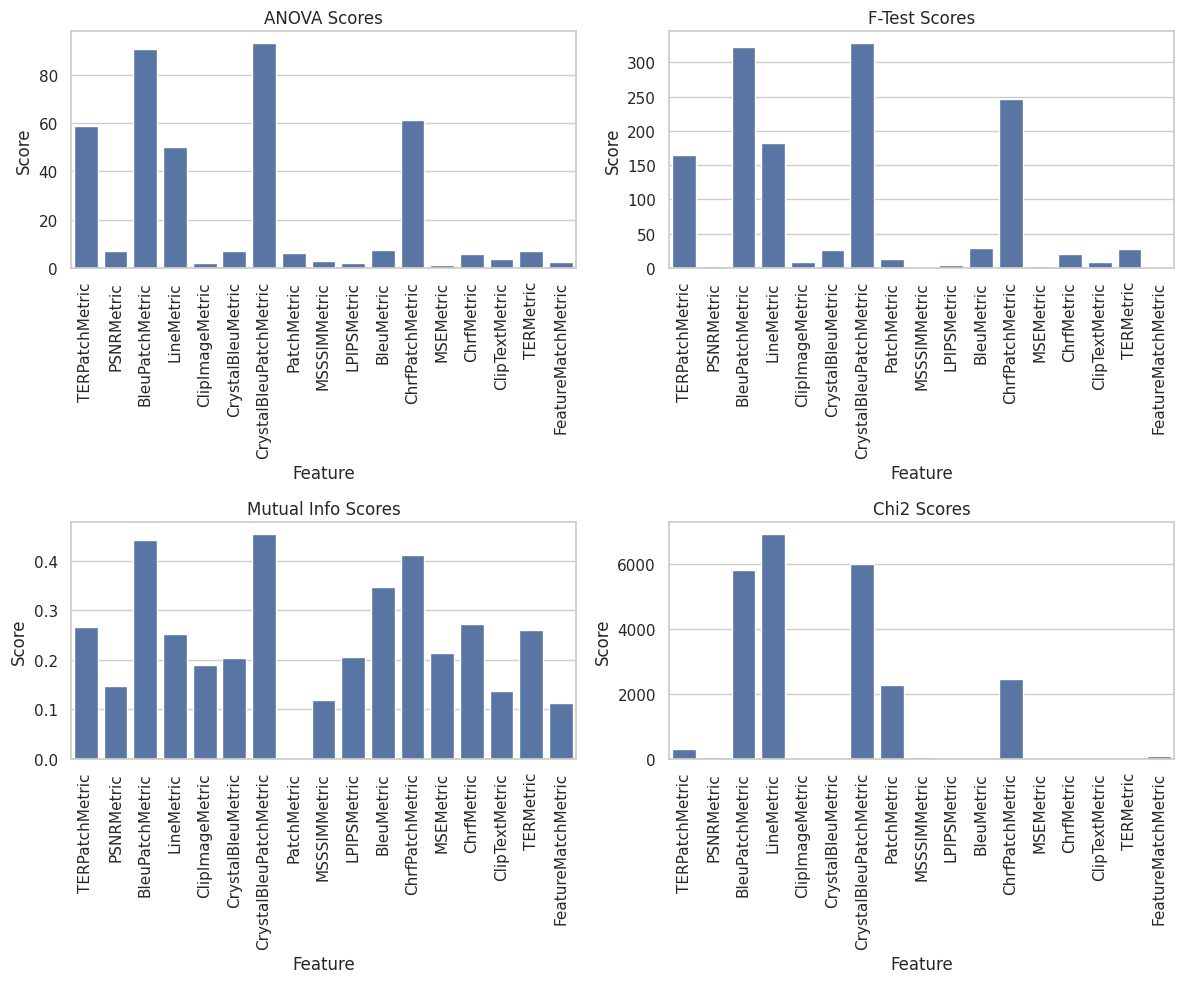

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming X_train is a DataFrame
feature_names = X_train.columns

# Creating a DataFrame for visualization
data = pd.DataFrame({
    'Feature': feature_names,
    'ANOVA': ANOVA_scores,
    'F-Test': f_test_scores,
    'Mutual Info': mutual_info_scores,
    'Chi2': chi2_scores
})

# Melting DataFrame for Seaborn
melted_data = data.melt(id_vars=['Feature'], var_name='Method', value_name='Score')

# Plot each method separately
methods = ['ANOVA', 'F-Test', 'Mutual Info', 'Chi2']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, method in enumerate(methods):
    sns.barplot(x='Feature', y='Score', data=melted_data[melted_data['Method'] == method], ax=axes[i])
    axes[i].set_title(f'{method} Scores')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()



### Model-based feature selection

#### RFE(Recursive Feature Elimination) with cross-validation for ordinal outputs

Notes on ridge regression:

In [119]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1 
rf = RandomForestClassifier(n_estimators=500,max_depth=5, random_state=42, min_samples_split=3)
cv = StratifiedKFold(20)
rfecv = RFECV(
    estimator=rf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=20, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(max_depth=5, min_samples_split=3,
                                       n_estimators=500, random_state=42),
      n_jobs=2, scoring='accuracy')

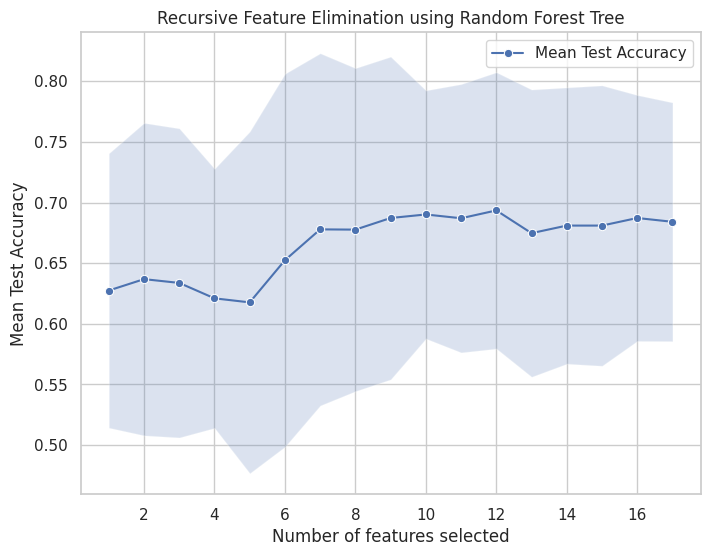

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create DataFrame from RFECV results
cv_results = pd.DataFrame(rfecv.cv_results_)

# Set Seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(8, 6))
sns.lineplot(
    x=cv_results["n_features"], 
    y=cv_results["mean_test_score"], 
    marker="o", 
    label="Mean Test Accuracy")

# Add error bars
plt.fill_between(
    cv_results["n_features"],
    cv_results["mean_test_score"] - cv_results["std_test_score"],
    cv_results["mean_test_score"] + cv_results["std_test_score"],
    alpha=0.2
)

# Labels and title
plt.xlabel("Number of features selected")
plt.ylabel("Mean Test Accuracy")
plt.title("Recursive Feature Elimination using Random Forest Tree")
plt.legend()
plt.show()

In [121]:
rankings = rfecv.ranking_
feature_names = rfecv.feature_names_in_
feature_ranking = pd.DataFrame({
    'Feature': feature_names,
    'Rank': rankings
})
sorted_feature_ranking = feature_ranking.sort_values(by='Rank')
print("Features ordered by rank:")
print(sorted_feature_ranking)

Features ordered by rank:
                   Feature  Rank
0           TERPatchMetric     1
2          BleuPatchMetric     1
3               LineMetric     1
4          ClipImageMetric     1
6   CrystalBleuPatchMetric     1
11         ChrfPatchMetric     1
10              BleuMetric     1
9              LPIPSMetric     1
14          ClipTextMetric     1
13              ChrfMetric     1
15               TERMetric     1
12               MSEMetric     1
5        CrystalBleuMetric     2
16      FeatureMatchMetric     3
1               PSNRMetric     4
8             MSSSIMMetric     5
7              PatchMetric     6


#### Permutation importance using RandomForest, Logistic ordinal regression and Ridge

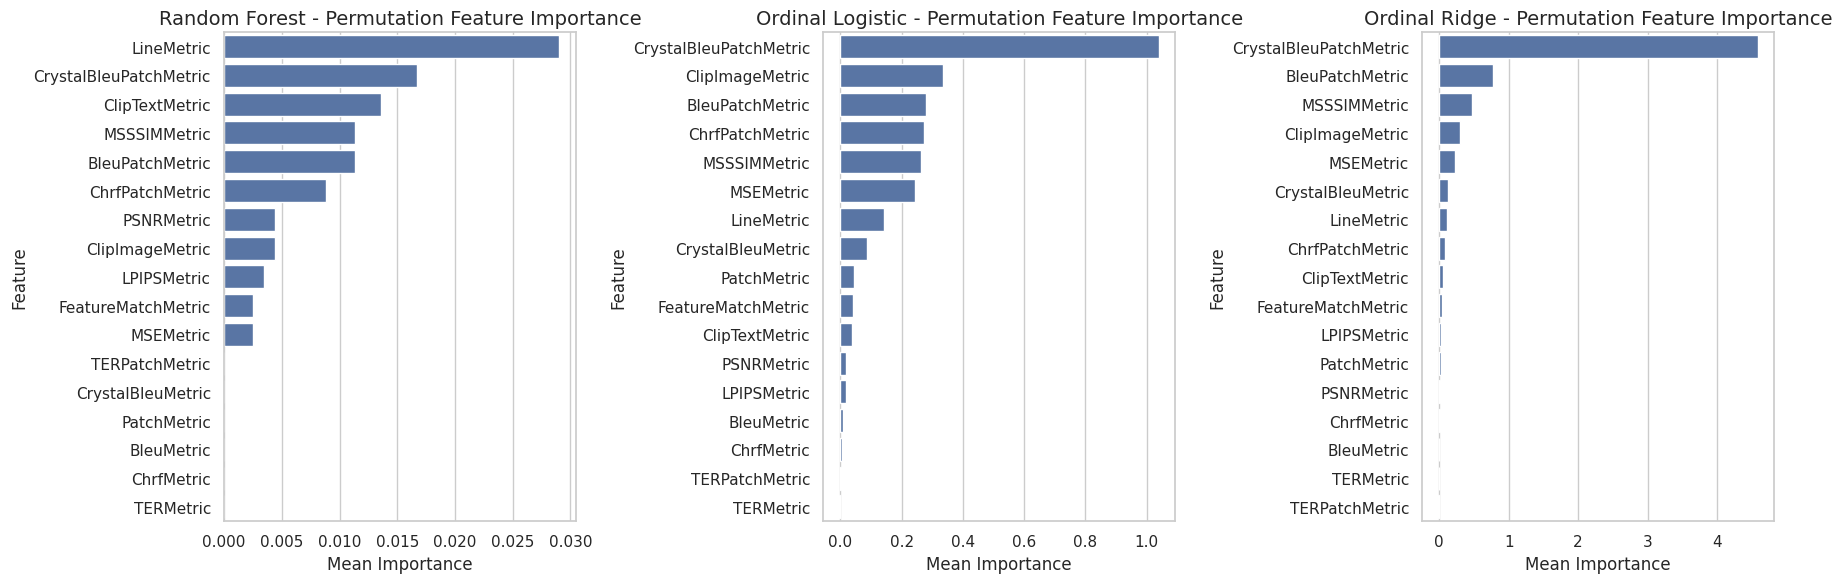

In [122]:
from mord import LogisticAT, OrdinalRidge 
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# Suppress specific warning
warnings.filterwarnings("ignore", message="X has feature names")
# Define models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=123456),
    'Ordinal Logistic': LogisticAT(),
    'Ordinal Ridge': OrdinalRidge()
}

# Create a 1x3 grid of subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop over each model and plot its feature importance
for ax, (model_name, model) in zip(axes, models.items()):
    
    # Fit the model and calculate permutation importance
    model.fit(X, y)
    result = permutation_importance(model, X, y, n_repeats=10, random_state=123456)
    
    # Create DataFrame for the model's importance
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean
    })
    
    # Sort features by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot on the corresponding axis
    sns.barplot(x='Importance', y='Feature', data=importance_df, ax=ax)
    ax.set_title(f'{model_name} - Permutation Feature Importance', fontsize=14)
    ax.set_xlabel('Mean Importance', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


#### Coefficient values of Logistic models

In [123]:
from mord import LogisticAT,OrdinalRidge 

ordinal_logit = LogisticAT()
ordinal_ridge = OrdinalRidge()
ordinal_logit.fit(X, y)
ordinal_ridge.fit(X, y)
ordinal_logit_scores = np.abs(ordinal_logit.coef_).flatten()  # Absolute value of coefficients
ordinal_ridge_scores = np.abs(ordinal_ridge.coef_).flatten()  # Absolute value of coefficients
feature_names = X.columns


    
    # Create a DataFrame for better presentation and sorting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'logit_importance': ordinal_logit_scores,
    'ridge_importance': ordinal_ridge_scores
})


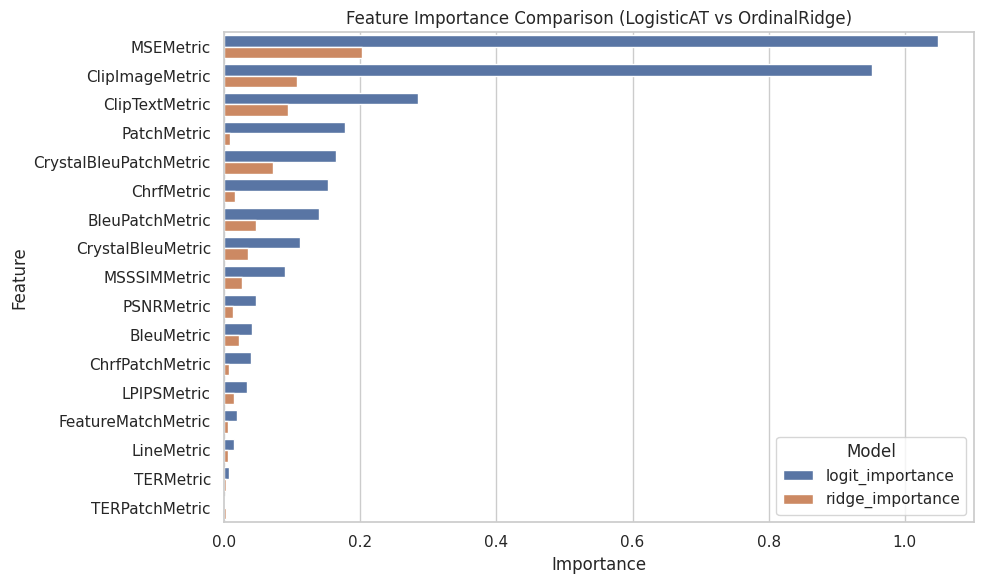

In [124]:
# Melt the DataFrame for seaborn plotting
importance_df = importance_df.melt(id_vars=['Feature'], var_name='Model', value_name='Importance')

# Sort values by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create the seaborn plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', hue='Model', orient='h')
plt.title('Feature Importance Comparison (LogisticAT vs OrdinalRidge)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [125]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Ordinal Accuracy function (within 1 class tolerance)
def ordinal_accuracy(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) <= 1)

# Fit models
ordinal_logit = LogisticAT()
ordinal_ridge = OrdinalRidge()
rf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=42, min_samples_split=3)

# Cross-validation with MSE
logit_cv_score = cross_val_score(ordinal_logit, X, y, cv=5, scoring='neg_mean_squared_error')
ridge_cv_score = cross_val_score(ordinal_ridge, X, y, cv=5, scoring='neg_mean_squared_error')
rf_cv_score = cross_val_score(rf, X, y, cv=5, scoring='accuracy')  # For RF, use accuracy for classification

# Output mean MSE and accuracy for cross-validation
print(f"Ordinal Logistic CV MSE: {-logit_cv_score.mean()}")
print(f"Ordinal Ridge CV MSE: {-ridge_cv_score.mean()}")
print(f"Random Forest CV Accuracy: {rf_cv_score.mean()}")

# Now, let's test using the test data
ordinal_logit.fit(X_train, y_train)
ordinal_ridge.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Make predictions on test data
logit_preds = ordinal_logit.predict(X_test)
ridge_preds = ordinal_ridge.predict(X_test)
rf_preds = rf.predict(X_test)

# Compute MSE on test data
logit_mse = mean_squared_error(y_test, logit_preds)
ridge_mse = mean_squared_error(y_test, ridge_preds)
rf_mse = mean_squared_error(y_test, rf_preds)

# Print MSE on test data
print(f"Ordinal Logistic MSE on Test: {logit_mse}")
print(f"Ordinal Ridge MSE on Test: {ridge_mse}")
print(f"Random Forest MSE on Test: {rf_mse}")

# Compute Ordinal Accuracy on test data
logit_ord_acc = ordinal_accuracy(y_test, logit_preds)
ridge_ord_acc = ordinal_accuracy(y_test, ridge_preds)
rf_ord_acc = ordinal_accuracy(y_test, rf_preds)

# Print Ordinal Accuracy on test data
print(f"Ordinal Logistic Ordinal Accuracy on Test: {logit_ord_acc}")
print(f"Ordinal Ridge Ordinal Accuracy on Test: {ridge_ord_acc}")
print(f"Random Forest Ordinal Accuracy on Test: {rf_ord_acc}")


Ordinal Logistic CV MSE: 1.3783730158730159
Ordinal Ridge CV MSE: 1.2007440476190478
Random Forest CV Accuracy: 0.5896825396825397
Ordinal Logistic MSE on Test: 0.46875
Ordinal Ridge MSE on Test: 0.875
Random Forest MSE on Test: 0.46875
Ordinal Logistic Ordinal Accuracy on Test: 0.96875
Ordinal Ridge Ordinal Accuracy on Test: 0.875
Random Forest Ordinal Accuracy on Test: 0.90625


# Inter rater agreement
Measuring the IRA in case of multiple raters, using Intra-class correlation, better suiting for ordinal scales.
Using both consistency and absolute agreement measurement(measurement relatively the same/ absolutely the same)

In [ ]:
import pingouin as pg
import pandas as pd

# Example dataset: multiple raters evaluating the same subjects


# Compute ICC
df_icc = df[["id","reviewer_id","human_score"]]
icc = pg.intraclass_corr(data=data, targets='id', raters='reviewer_id', ratings='human_score')#nan_policy="omit")# omit when unbalanced amount of rating

# Display results
print(icc)


    Type              Description       ICC             F  df1  df2      pval  \
0   ICC1   Single raters absolute  0.988258  2.535000e+02    1    4  0.000091   
1   ICC2     Single random raters  0.988304 -3.805542e+15    1    2  1.000000   
2   ICC3      Single fixed raters  1.000000 -3.805542e+15    1    2  1.000000   
3  ICC1k  Average raters absolute  0.996055  2.535000e+02    1    4  0.000091   
4  ICC2k    Average random raters  0.996071 -3.805542e+15    1    2  1.000000   
5  ICC3k     Average fixed raters  1.000000 -3.805542e+15    1    2  1.000000   

         CI95%  
0  [0.87, 1.0]  
1  [0.69, 1.0]  
2   [1.0, 1.0]  
3  [0.95, 1.0]  
4  [0.87, 1.0]  
5   [1.0, 1.0]  


# Correlations with ast difficulty

In [30]:
import pandas as pd
df_difficulty = full_df[
    [col_name for col_name in full_df.columns if "Metric" in col_name or "human_score" in col_name or "difficulty" in col_name]
]

grped = (
    df_difficulty.groupby(list(set(df_difficulty.columns) - {"human_score"}))
    .mean()
    .round(0)  # Round to the nearest integer
    .astype(int)  # Convert to integer type
    .reset_index()
)
df_difficulty = grped
df_difficulty['difficulty'] = pd.Categorical(df_difficulty['difficulty'])
df_difficulty['difficulty'] = pd.factorize(df_difficulty['difficulty'])[0]


<Axes: >

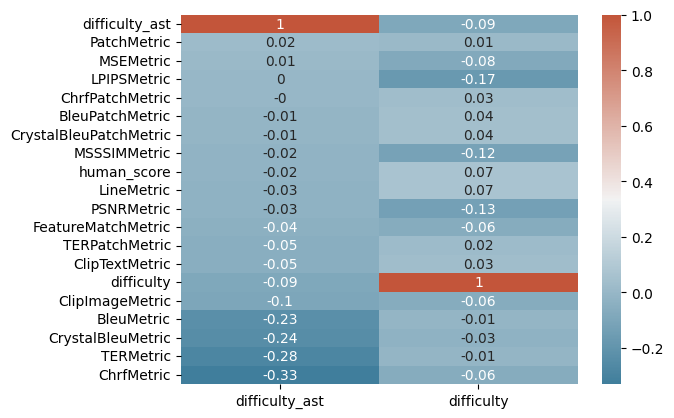

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = df_difficulty.corr("kendall")
corr = corr.round(2)
sorted_corr = corr[["difficulty_ast","difficulty"]].sort_values(by="difficulty_ast", ascending=False)  # Sort descending

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(sorted_corr, annot=True, cmap=cmap)


The perceived difficulty by the humans is not inversely correlated with the capacity of an LLM to make the right edits 